# PCA Baseline

We first demonstrate PCA-based degeneracy detection on power spectrum posterior samples.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from posterior import generate_cosmology_posterior
from pca import pca_analysis

We first create posterior samples using MCMC inference on a matter power spectrum.
The syren emulator computes P(k) given cosmological parameters (Ωₘ, h), and emcee samples from the posterior.

In [2]:
# Generate synthetic data
# This runs emcee to sample from P(Om, h | P(k)_obs)
samples, info = generate_cosmology_posterior(
    n_samples=8000,
    theta_true=np.array([0.32, 0.67]),  # True parameters [Om, h]
    seed=42,
    verbose=True
)

print(f"\nSamples shape: {samples.shape}")
print(f"Parameters: {info['param_names']}")
print(f"True theta: Om={info['theta_true'][0]:.3f}, h={info['theta_true'][1]:.3f}")

Running MCMC: 2000 samples, 500 warmup, 4 walkers


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:02<00:00, 712.32it/s]


Samples shape: (8000, 2)
Parameters: ['Om', 'h']
True theta: Om=0.320, h=0.670


Then, we run a PCA analysis to identify linear degeneracies.

In [3]:
param_names = info['param_names']

pca_result = pca_analysis(samples, param_names)
pca_result.print_summary()

print("\nPairwise correlation:")
for p1, p2, corr in pca_result.get_degeneracy_pairs():
    print(f"  {p1} <-> {p2}: {corr:.3f}")

PC   Var Explained   Direction
--------------------------------------------------
PC1          98.9%    -0.71*Om +0.71*h
PC2           1.1%    -0.71*Om -0.71*h

Pairwise correlation:
  Om <-> h: 0.978


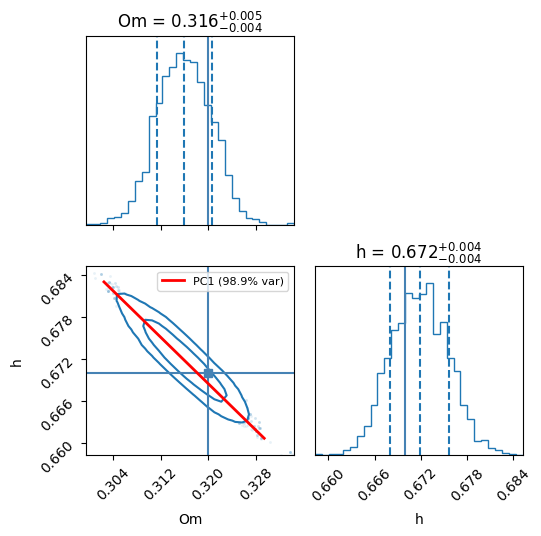


PCA Direction (PC1): [-0.70710678  0.70710678]
Explained variance: 98.9%


In [4]:
# Get the principal component direction (PC1, the main degeneracy)
pc1_direction = pca_result.components[0]  # Shape: (n_params,)
mean = pca_result.mean
std = pca_result.std

# Create corner plot
fig = corner.corner(
    samples,
    labels=param_names,
    truths=info['theta_true'],
    show_titles=True,
    title_fmt='.3f',
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_datapoints=True,
    plot_density=False,
    bins=30,
    smooth=1.0,
    color='C0',
    alpha=0.6
)

# Overlay PCA direction on the joint plot (Om vs h)
axes = np.array(fig.axes).reshape((2, 2))
ax_joint = axes[1, 0]

# Plot the PCA direction as a line through the mean
# The direction is given by the eigenvector (in standardized space)
# Scale by standard deviation to get back to original space
t_vals = np.linspace(-3, 3, 100)
pca_line = mean[:, None] + (pc1_direction * std)[:, None] * t_vals * np.sqrt(pca_result.eigenvalues[0])

ax_joint.plot(
    pca_line[0], 
    pca_line[1], 
    'r-', 
    linewidth=2, 
    label=f'PC1 ({pca_result.explained_variance[0]*100:.1f}% var)',
    zorder=10
)
ax_joint.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nPCA Direction (PC1): {pc1_direction}")
print(f"Explained variance: {pca_result.explained_variance[0]*100:.1f}%")